<font size=8>Create Synthetic WOD - TSM sandbox</font>

This notebook subsamples the output of a numerical ocean model using the locations of observations from the World Ocean Database
The xESMF tool is used to subsample the model temperature and salinity fields



In [1]:
import os
import dask
import numpy as np
import pandas as pd
import dask.array as dask
import dask.bag as db
from matplotlib import pyplot as plt
import xarray 
import xesmf

In [2]:
xarray.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

## small local cluster

## Big cluster

In [3]:
import os
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster
walltime = '01:30:00'
cores = 48
memory = '192GB'
  
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normal','-P xv83','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/xv83+gdata/v14+gdata/ux62+scratch/xv83+gdata/rt52+gdata/ik11+gdata/cj50+gdata/jk72+gdata/hh5'],
                     local_directory='$TMPDIR',
                     header_skip=["select"])
cluster.scale(jobs=2)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:293: FutureWarning: header_skip has been renamed to job_directives_skip. You are still using it (even if only set to []; please also check config files). If you did not set job_directives_skip yet, header_skip will be respected for now, but it will be removed in a future release. If you already set job_directives_skip, header_skip is ignored and you can remove it.
  warnings.warn(warn

In [4]:
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/46607/status,
Dashboard: /proxy/46607/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.1:40727,Workers: 0
Dashboard: /proxy/46607/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Can we use the CC to load up this data?

In [ ]:
import cosima_cookbook as cc

In [ ]:
%%time
session = cc.database.create_session()
monthly_temp = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='temp', session=session, frequency='1 monthly', start_time='1987', end_time='2019')

In [ ]:
monthly_temp

# Note: below requires over 16GB of local RAM?

In [ ]:
%%time
session = cc.database.create_session()
daily_temp = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='temp', session=session, frequency='1 daily', start_time='1987', end_time='2019', return_dataset=True)

In [ ]:
daily_temp

## Load the model field (here from the 0.1 degree COSIMA model suite)

# switch

In [ ]:
model_temperature_dataset = daily_temp

# 34TB!

In [ ]:
model_temperature_dataset.nbytes/1e9

In [ ]:
grid010 = xarray.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})

In [ ]:
grid010

In [ ]:
model_temperature_dataset = model_temperature_dataset.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
model_temperature_dataset = model_temperature_dataset.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                                                              'geolon_t': 'longitude', 'geolat_t': 'latitude'})


In [ ]:
model_temperature_dataset['temp'][0,0,:,:].plot()

In [ ]:
#lon_name = 'xt_ocean'
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] + 360)  % 360})
#model_temperature_dataset.sortby(model_temperature_dataset)
#ds_out = ds_out.assign_coords({'lon': ds_out.lon - 100.})
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] + (90+280)) % 360})
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] - 100)})

# I believe for xESMF to not bog down *ALL* space must be in one chunk?

In [ ]:
%%time
model_temperature_dataset = model_temperature_dataset.chunk({'time':1,'st_ocean':-1,'x':-1,'y':-1})

In [ ]:
model_temperature_dataset

# Load the World Ocean Database data


In [6]:
WOD_base_file_path ='/g/data/ul08/WOD_2018'

year = 2018
WOD_file_name_stem = 'wod_'


obs_platform_type = ['ctd','xbt','pfl','mrb','gld','drb','osd']

WOD_object = dict(zip(obs_platform_type, [None]*len(obs_platform_type)))


for i_platform_type in obs_platform_type:
    
    WOD_object[i_platform_type] = xarray.open_dataset(os.path.join(WOD_base_file_path,str(2018),
                                                                   WOD_file_name_stem + i_platform_type + '_' + str(year) + '.nc') )
    


In [7]:
platform_type = 'xbt'

WOD_lat = WOD_object[platform_type]['lat'].copy().values
WOD_lon = WOD_object[platform_type]['lon'].copy().values


In [8]:
WOD_lon[WOD_lon>90] = WOD_lon[WOD_lon>90] - (270+90) 

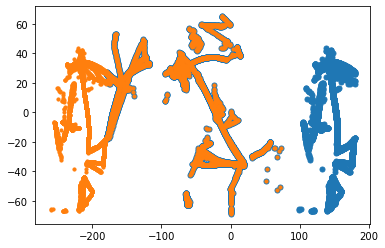

In [9]:
plt.scatter(WOD_object[platform_type]['lon'],WOD_object[platform_type]['lat'],s=25)
plt.scatter(WOD_lon,WOD_lat,s=10)


In [10]:
ds_WOD_stations = xarray.Dataset()
ds_WOD_stations['longitude'] = xarray.DataArray(data=WOD_lon, dims=('casts'))
ds_WOD_stations['latitude'] = xarray.DataArray(data=WOD_lat, dims=('casts'))
ds_WOD_stations['time'] = xarray.DataArray(data=WOD_object[platform_type]['time'].values, dims=('casts'))

ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['longitude']>-280,
                                                       ds_WOD_stations['longitude']<-180),drop=True)
ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['latitude']>-50,
                                                       ds_WOD_stations['latitude']<0),drop=True)


In [11]:
plt.contourf(model_temperature_dataset['temp']['xt_ocean'],model_temperature_dataset['temp']['yt_ocean'],
             model_temperature_dataset['temp'][0,0,:,:],25)
plt.scatter(ds_WOD_stations['longitude'],ds_WOD_stations['latitude'])

#plt.scatter(WOD_lon,WOD_lat,s=10)


NameError: name 'model_temperature_dataset' is not defined

In [ ]:
WOD_object['pfl']['z'].max()

In [ ]:
#model_temperature = model_temperature.drop({'x', 'y'}).cf.to_dataset()


#model_temperature = model_temperature.sel(time=ds_WOD_stations['time'].values,method='nearest')

#model_temperature = model_temperature.chunk({'time':5,'st_ocean':-1,'y':-1,'x':-1})

In [ ]:
max_depth = 800

n_levels = model_temperature_dataset['st_ocean'].sel(st_ocean=slice(0,max_depth)).size
n_casts  = ds_WOD_stations['casts'].size
KELVIN_TO_CELSIUS = -273.15



WOD_temperature_synthetic = xarray.DataArray(np.zeros([n_casts,n_levels],dtype=np.float32),
                                             dims=['casts','depth'],
                                             coords={'casts':ds_WOD_stations['casts'],
                                                     'depth':model_temperature_dataset['st_ocean'][0:n_levels].values}).to_dataset(name='temp')
WOD_temperature_synthetic['latitude'] = ds_WOD_stations['latitude']


WOD_temperature_synthetic['longitude'] = ds_WOD_stations['longitude']
WOD_temperature_synthetic['time'] = ds_WOD_stations['time']



#model_temperature_level = model_temperature_dataset['temp'].sel(st_ocean=slice(0,max_depth)) 


for i_level in range(25,n_levels):
    model_temperature_level = model_temperature_dataset['temp'].isel(st_ocean=i_level).load() 
    model_temperature_level = model_temperature_level + KELVIN_TO_CELSIUS
    
    
    regridder = xesmf.Regridder(model_temperature_level, ds_WOD_stations, 'bilinear', locstream_out=True) #,reuse_weights=True)
    
    WOD_temperature_synthetic_level = regridder(model_temperature_level)
    WOD_temperature_synthetic_level.to_netcdf(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging', 
                                                           'WOD_synthetic_' + platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') ) 
    
    
    WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level.sel(time=ds_WOD_stations['time'],method='nearest')
    
    


In [ ]:
WOD_temperature_synthetic_level

In [ ]:


for i_level in range(0,n_levels):
    #Get the slice for the current synthetic layer
    WOD_temperature_synthetic_level = xarray.open_dataset(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging', 
                                                           'WOD_synthetic_' + platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') )
    WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level['__xarray_dataarray_variable__'].sel(time=ds_WOD_stations['time'],method='nearest')
    WOD_temperature_synthetic_level.close()

In [ ]:
WOD_temperature_synthetic['temp'][20,:].plot()

In [ ]:
model_temperature_level

In [ ]:
model_temperature_level

In [ ]:
plt.scatter(WOD_temperature_synthetic['longitude'],WOD_temperature_synthetic['latitude'],c=WOD_temperature_synthetic['temp'][:,0],vmin=10,vmax=35)
plt.colorbar()

In [ ]:
model_temperature_level[0,:,:].plot(vmin=10,vmax=35)

In [ ]:
model_temperature_level

In [ ]:
regridder.to_netcdf('/g/data4/ul08/CARS_v2/regrid_weights_xbt.nc')

In [ ]:
test_xbt.compute()

In [ ]:
unique_days = np.unique(ds_WOD_stations['time.dayofyear'])

In [ ]:
for i_day in unique_days:
    
    model_temperature_dayofyear = model_temperature.sel(time=model_temperature['time'].dt.dayofyear.isin([i_day]))
    WOD_time_index = ds_WOD_stations['time'].dt.dayofyear.isin([i_day])
    ds_WOD_stations_dayofyear = ds_WOD_stations.where(WOD_time_index,drop=True)
    

    dsa
    

In [ ]:
WOD_time_index

In [ ]:
ds_WOD_stations_dayofyear

In [ ]:
ds_WOD_stations

In [ ]:
regridder = xesmf.Regridder(model_temperature, ds_WOD_stations, 'bilinear', locstream_out=True)


In [ ]:
regridder

In [ ]:
WOD_temperature_synthetic = regridder(model_temperature).compute()



In [ ]:
WOD_temperature_synthetic

In [ ]:
model_temperature

In [ ]:
WOD_temperature_synthetic['temp'][0,:,0].plot()

In [13]:
client.shutdown()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:293: FutureWarning: header_skip has been renamed to job_directives_skip. You are still using it (even if only set to []; please also check config files). If you did not set job_directives_skip yet, header_skip will be respected for now, but it will be removed in a future release. If you already set job_directives_skip, header_skip is ignored and you can remove it.
  warnings.warn(warn